# Example: CR3BP filtering with angles only measurements

2024.04.30, Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append('../')
import rudolfpy as rd

/Users/yuri/miniconda3/envs/grb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# initialize integrator
mu = 1.215058560962404e-02
LU = 389703
TU = 382981
VU = LU / TU
dynamics = rd.DynamicsCR3BP(mu = mu, method='DOP853', rtol = 1e-12, atol = 1e-12)

# initial state, propagation time
x0 = np.array([1.0809931218390707E+00,
    0.0000000000000000E+00,
    -2.0235953267405354E-01,
    1.0157158264396639E-14,
    -1.9895001215078018E-01,
    7.2218178975912707E-15])
period = 2.3538670417546639E+00
tspan = (0, period)

In [3]:
rd.get_perturbation_T(0.04)

array([[ 9.99797378e-01, -1.46121012e-02,  1.38451974e-02],
       [ 1.46014772e-02,  9.99893016e-01,  8.68118825e-04],
       [-1.38564013e-02, -6.65782590e-04,  9.99903774e-01]])

In [4]:
# initialize position measurements object
meas_model = rd.MeasurementAngleAngleRate()

# initialize EKF
params_Q = [1e-7,]
filter = rd.ExtendedKalmanFilter(dynamics, meas_model,
                                 func_process_noise = rd.unbiased_random_process_3dof,
                                 params_Q = params_Q,)
filter.summary()

 ************** ExtendedKalmanFilter summary ************** 
   Dynamics model : rhs_cr3bp
   Process noise model : unbiased_random_process_3dof


In [5]:
# initial state estimate
sigma_r0 = 100 / LU
sigma_v0 = 0.001 / VU
x0hat = x0 + np.array([sigma_r0]*3 + [sigma_v0]*3) * np.random.normal(0, 1, 6)
P0 = np.diag([sigma_r0]*3 + [sigma_v0]*3)**2

# create recursion object
recursor = rd.Recursor(filter)

In [6]:
# measurement frequency and simulation function
sigma_r = 100 / LU
t_measurements = np.linspace(0.05, 3 * period, 10)
sol_true = filter.dynamics.solve([0.0,t_measurements[-1]], x0, t_eval=t_measurements)

# define observer state
x0_obs = np.array([
    6.8263124956044707E-1, 0.0, 0.0,
    0.0, 6.7700103587008842E-1, 0.0
])
sol_obs  = filter.dynamics.solve([0.0,t_measurements[-1]], x0_obs, t_eval=t_measurements)

# define measurements
sigma_phi = np.deg2rad(3)
dt_meas = 3600/TU
y_measurements, R_measurements, params_measurements = [], [], []
for idx, t in enumerate(t_measurements):
    # generate measurement
    y, R = rd.func_simulate_measurement_angle_anglerate(
        t,
        sol_true.y[0:6,idx],
        [sol_obs.y[0:6,idx], sigma_phi, dt_meas]
    )
    y_measurements.append(y)
    R_measurements.append(R)
    params_measurements.append(sol_obs.y[0:6,idx])


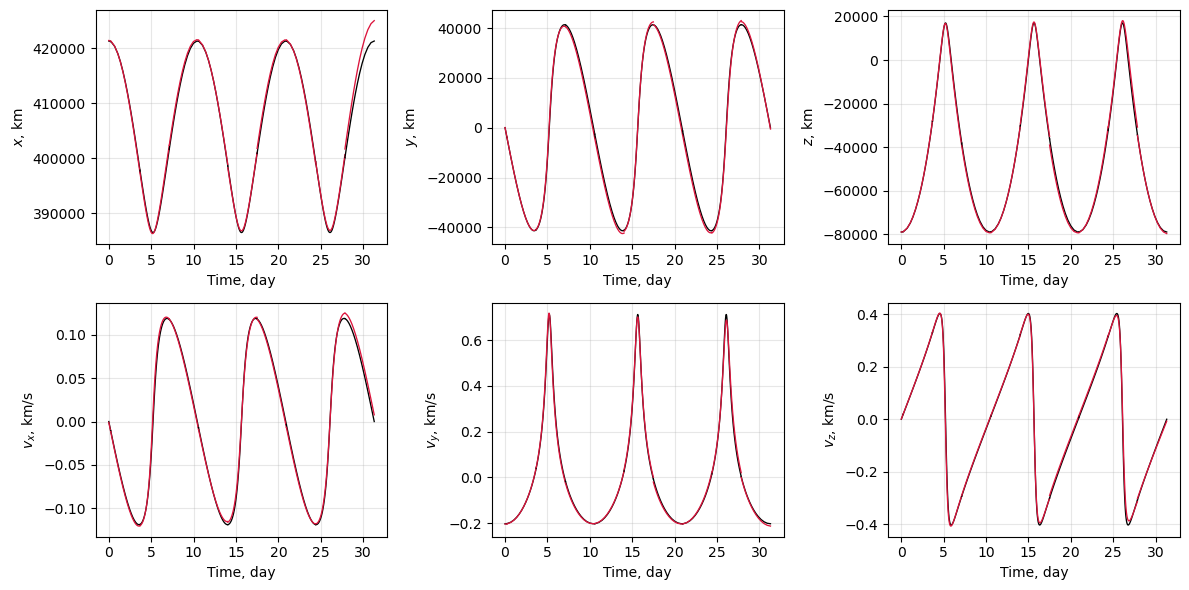

In [7]:
# perform recursion
recursor.recurse_measurements_list(
    [0.0, t_measurements[-1]],
    x0,
    x0hat,
    P0,
    t_measurements,
    y_measurements,
    R_measurements,
    params_measurements = params_measurements,
)

# plot recursion results
fig, axs = recursor.plot_state_history(
    TU = TU/86400,
    time_unit = "day",
    state_multipliers = [LU,LU,LU,VU,VU,VU],
    state_labels = ["$x$, km","$y$, km","$z$, km",
                    "$v_x$, km/s","$v_y$, km/s","$v_z$, km/s"],
)


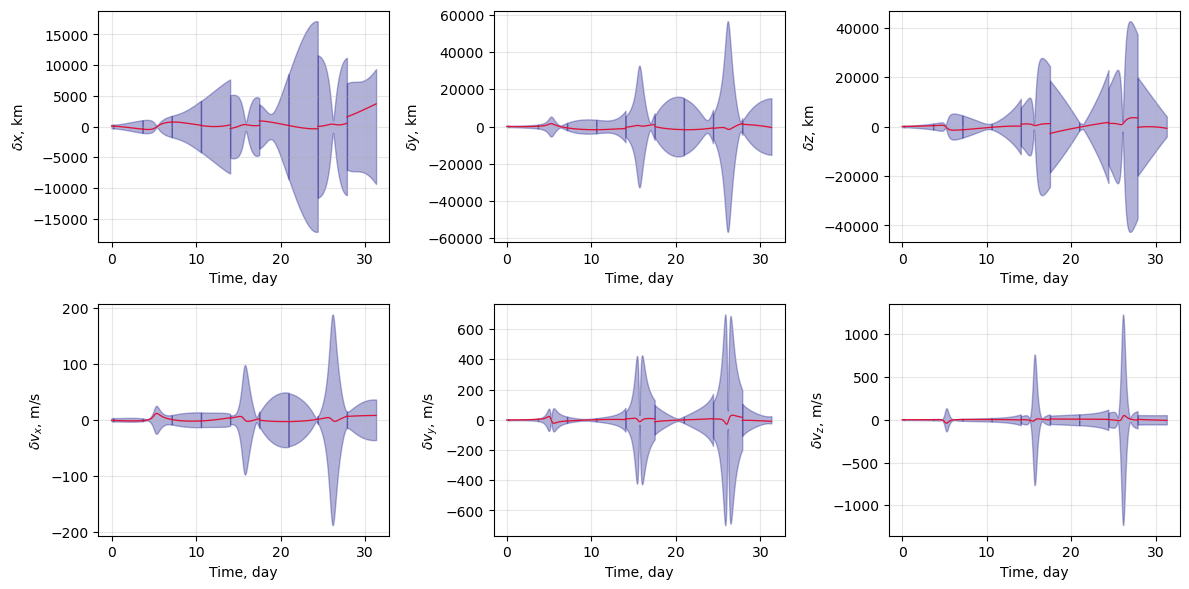

In [8]:

fig, axs = recursor.plot_error_history(
    TU = TU/86400,
    time_unit = "day",
    state_multipliers = [LU,LU,LU,1e3*VU,1e3*VU,1e3*VU],
    state_labels = ["$\delta x$, km","$\delta y$, km","$\delta z$, km",
                    "$\delta v_x$, m/s","$\delta v_y$, m/s","$\delta v_z$, m/s"],
)